_Version log: Branch of V24. Testing baselines hypothesis_

In [1]:
import sys, warnings
from sklearn.linear_model import Lasso #I'm using scikit insted of svxpy to solve.
from sklearn.exceptions import ConvergenceWarning
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft as spfft
from tqdm import tqdm
warnings.filterwarnings("ignore", category= ConvergenceWarning)
plt.rcParams.update({'font.size':16})
#np.set_printoptions(threshold=sys.maxsize)

In [2]:
def open_dataset(file_name, file_type):
    if file_type == ".csv":
        array = np.genfromtxt("data\\" +file_name +file_type, delimiter=",", filling_values= np.nan)
        if array.ndim == 2:
            return array.T
    elif file_type == ".txt":
        array = np.genfromtxt("data\\" +file_name +file_type, delimiter=",", filling_values= np.nan)
    else:
        raise ValueError("{0:} is not a regonised file type.".format(file_type))
    return array

def compressed_sensing(samples, locations, total_points, alpha):

    cropping_matrix = np.identity(total_points, dtype= np.float16)
    cropping_matrix = cropping_matrix[locations] #cropping matrix operator
    dct_matrix = spfft.idct(np.identity(total_points), axis= 0, norm= "forward")
    measurement_matrix = np.matmul(cropping_matrix, dct_matrix)

    lasso = Lasso(alpha= alpha)
    lasso.fit(measurement_matrix, samples)

    result = spfft.idct(lasso.coef_, norm= "forward")

    return result


def subsample_1d(total_points, subsampling_percentage = 0.5, detector_size = 1):
    reduced_points = round(total_points *subsampling_percentage)
    subsampled_points = np.round(np.linspace((detector_size-1)//2, total_points +((1-detector_size)//2), reduced_points)).astype(int)
    subsampled_points = np.sort(subsampled_points) #Nessisary only for optimisation.

    return subsampled_points

def binned_mean(index, y ,width):
    means = np.array([])
    for i in index:
        mean = np.mean(y[i +1 +(-width//2): i +1 +(width//2)])
        means = np.append(means, mean)
    return means

In [3]:
file_name = "1dmockanderrors12"
file_type = ".csv"

target, uncertainties = open_dataset(file_name, file_type)
#uncertainties = np.ones_like(uncertainties)
total_points = len(target)

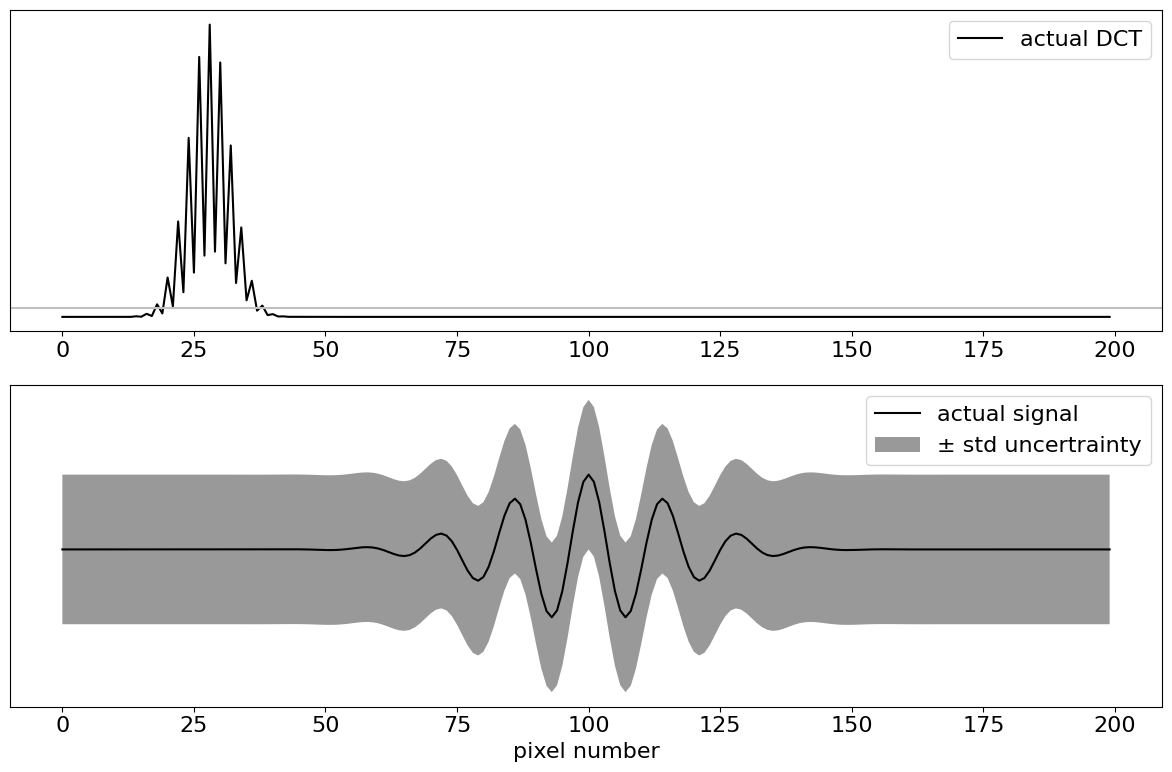

In [4]:
target_DCT = spfft.dct(target, norm= "forward")

threshold = np.abs(target_DCT).mean()

plt.rcParams.update({'font.size':16})
fig, axs = plt.subplots(2,1, figsize= (12,8))

axs[0].plot(np.abs(target_DCT), color= "k", label= "actual DCT")
axs[0].hlines(threshold, 0, 1, color= "silver", transform=axs[0].get_yaxis_transform())

axs[1].plot(target, color= "k", label= "actual signal")
axs[1].fill_between(range(total_points), target-uncertainties, target+uncertainties, facecolor= "gray", alpha= 0.8, label= "± std uncertrainty")
axs[1].set(xlabel= "pixel number")

[ax.legend(loc= 'upper right') for ax in axs]
[ax.set(yticks= []) for ax in axs]

plt.tight_layout()
plt.show()


C:\Users\syf83691\AppData\Local\Temp\ipykernel_11828\1741690778.py:4: RuntimeWarning: divide by zero encountered in divide
  wavelengths = 1/freqs #in pixels


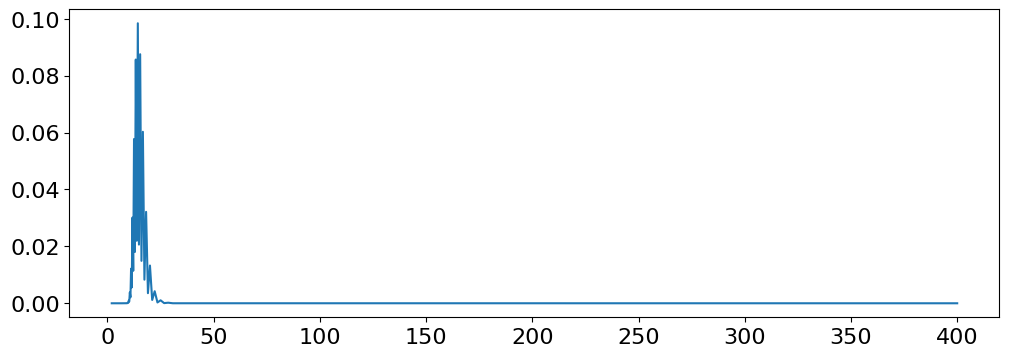

In [5]:
N = len(target_DCT)
k = np.arange(N)
freqs = k/(2*N) #in pixels^-1
wavelengths = 1/freqs #in pixels
freqs *= total_points #in "per array length"
wavelengths = np.nan_to_num(wavelengths, nan= np.nan, neginf= np.nan, posinf= np.nan)
half_wavelengths = wavelengths/2

fig, axs= plt.subplots(figsize= (12, 4))

axs.plot(wavelengths, np.abs(target_DCT))
#axs.set(xscale= "log")

plt.show()

In [6]:
reduced_points = 4

#I'm surprised that numpy and scipy don't have meathods for reading files with inconsistant numbers of delimiters.
optlocs_file = "data\\" + file_name +"_optlocs.csv"


with open(optlocs_file, 'r') as file:
    lines = [line[:-1] for line in list(file)]
    lines = [line for line in lines if line.count(",") == reduced_points-1] # filter by number of samples
    number_of_delimiters = [line.count(",") for line in lines]
    max_delimiters = max(number_of_delimiters)
    missing_delimiters = [max_delimiters -delimiters for delimiters in number_of_delimiters]
    data = [line.split(",") for line in lines]
    data = [[int(datapoint) for datapoint in line] for line in data] #2D list comprehention!!!!
    full_data = [data[n] + [np.nan]*missing_delimiters[n] for n in range(len(lines))]
    full_data = np.array(full_data)
    file.close()

print(len(lines))
print(total_points /reduced_points)

24
50.0


### REDUNDENT BASELINES

In [7]:
test = [90,92,94,96]

len(test)

4

In [8]:
full_data = np.vstack([full_data, test])
full_data.shape

(25, 4)

In [9]:
regularization_coeffient = 1e-4

def find_error(locations):
    assert locations.ndim == 1
    locations = locations[~np.isnan(locations)].astype(int)

    result = compressed_sensing(target[locations], locations, total_points, regularization_coeffient)
    error = np.linalg.norm((target -result) /uncertainties) #This is the chi-squared

    return error

errors = [find_error(locations) for locations in tqdm(full_data)]
errors = np.array(errors)


100%|██████████| 25/25 [00:00<00:00, 121.74it/s]


In [10]:
sort = np.argsort(errors)
print(errors[-1])
errors = errors[sort]
full_data = full_data[sort]

0.9477074614100814


In [11]:
full_data[:10,:]

array([[ 90,  92,  94,  96],
       [ 90,  92,  94,  96],
       [ 89,  96,  99, 104],
       [ 90,  93,  95,  96],
       [ 90,  93,  96, 108],
       [ 90,  93,  96, 122],
       [ 89, 102, 104, 173],
       [  2,   9, 102, 104],
       [ 19,  95,  97, 110],
       [  0,  26, 102, 104]])

[90 92 94 96]
0.9477074614100814


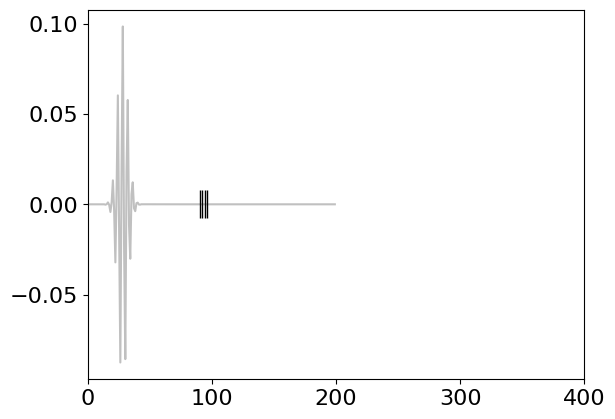

In [14]:
n = 0

print(full_data[n,:])
print(errors[n])

plt.plot(target_DCT, color= "silver")
plt.plot(full_data[n,:].T, np.zeros(reduced_points), linestyle= "none", marker= "|", markersize= 20, color= "k")
plt.xlim(0, 400)
plt.show()

In [15]:
def autocorrelate(x): #stolen from stack overflow
    x = x[~np.isnan(x)]
    x = x.astype(int)

    array = np.zeros(total_points)
    array[x] = 1.
    result = np.correlate(array, array, mode='full')
    return result[result.size//2:]

autocor = [autocorrelate(locations) for locations in full_data]
autocor = np.array(autocor)

In [16]:
autocor_indexs = [np.repeat(np.arange(total_points -1), autoco[1:].astype(int)) for autoco in autocor] #alternative data format for autocor. Excludes first point. Used for weighted mean and std.

In [17]:
def aliasing(baselines):
    m = np.arange(3)

    aliased_freqs = 1/(2*baselines[:,None]) + m[None,:]/baselines[:,None]
    aliased_freqs = np.sort(aliased_freqs.flatten())

    aliased_freqs = aliased_freqs[aliased_freqs <= 1/2]

    return aliased_freqs
        
aliased_freqs = [aliasing(autocor_index) for autocor_index in autocor_indexs]

C:\Users\syf83691\AppData\Local\Temp\ipykernel_11828\3218017979.py:4: RuntimeWarning: divide by zero encountered in divide
  aliased_freqs = 1/(2*baselines[:,None]) + m[None,:]/baselines[:,None]
C:\Users\syf83691\AppData\Local\Temp\ipykernel_11828\3218017979.py:4: RuntimeWarning: invalid value encountered in divide
  aliased_freqs = 1/(2*baselines[:,None]) + m[None,:]/baselines[:,None]


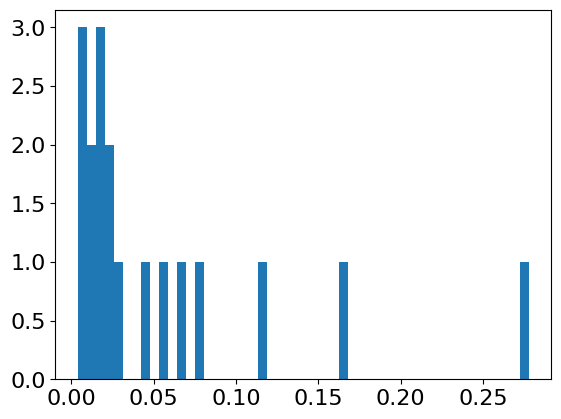

In [18]:
plt.hist(aliased_freqs[-1], bins= 50)
plt.show()

In [19]:
unique_baselines = np.sum(autocor > 0, axis= 1)
single_baselines = np.sum(autocor == 1, axis= 1)
double_baselines = np.sum(autocor == 2, axis= 1)
more_baselines = np.sum(autocor > 2, axis= 1)


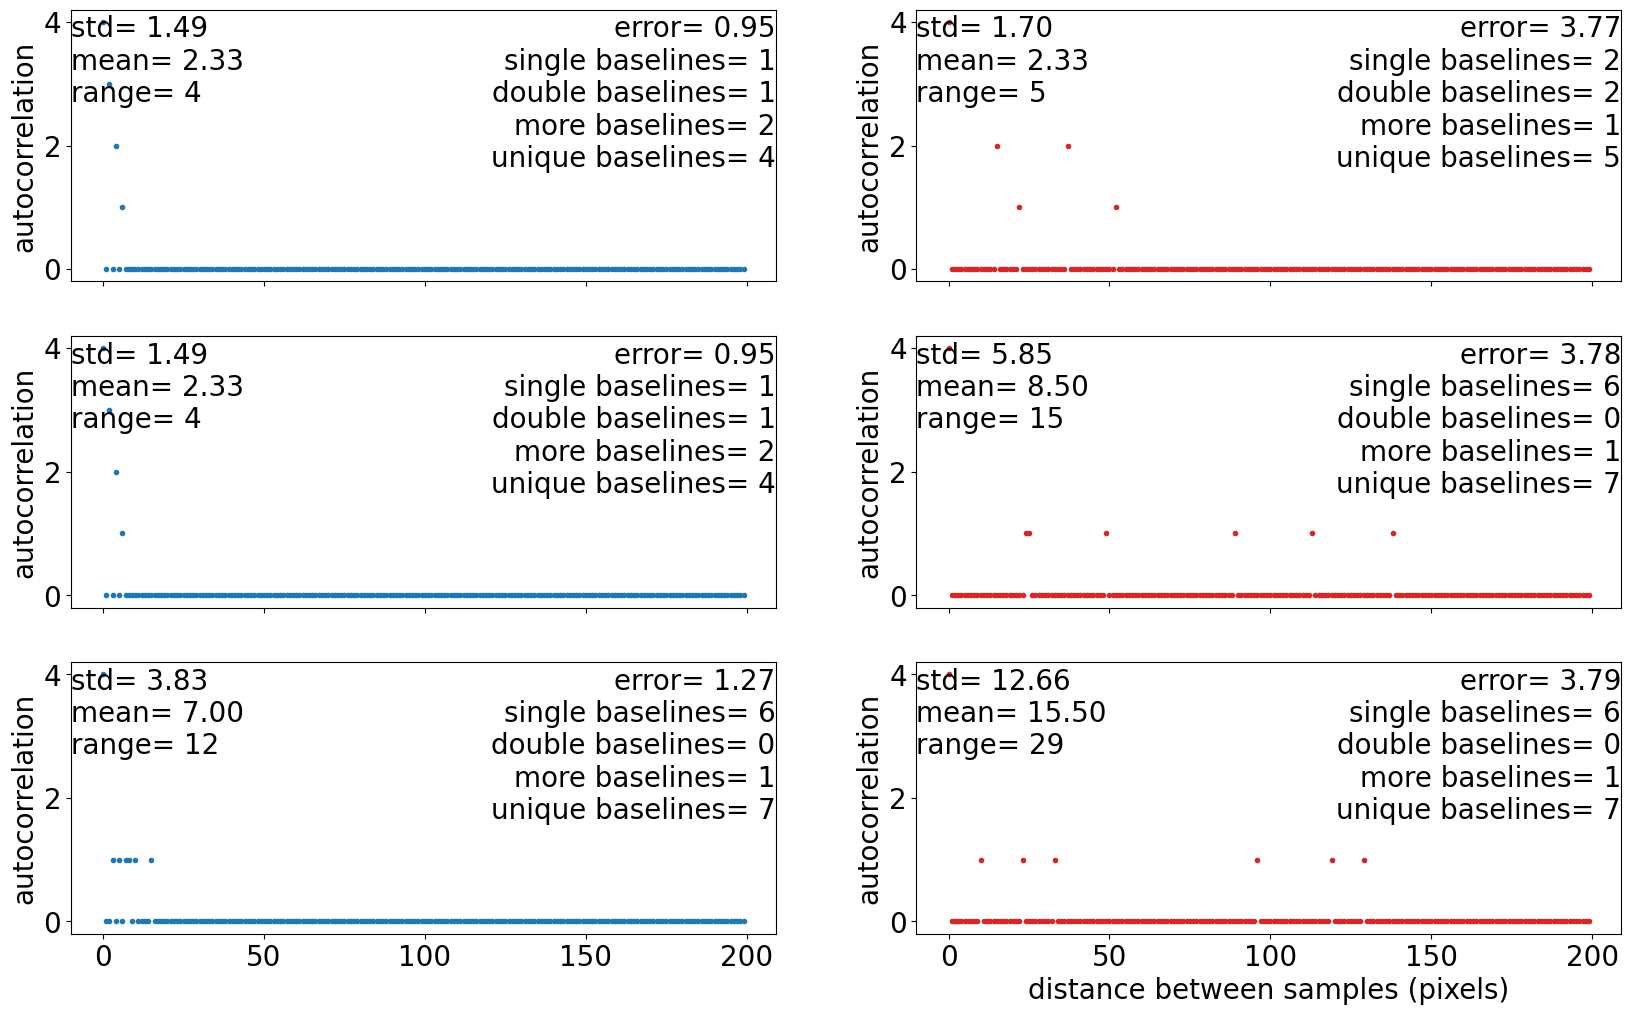

In [20]:
best, worst = 3, 3

plt.rcParams.update({"font.size": 20})

plots = np.arange(len(full_data))
plots = np.concatenate((plots[:best], plots[-worst:]))
colour = np.concatenate((["tab:blue"]*best, ["tab:red"]*worst))
n_plots = len(plots)

fig, axs = plt.subplots(n_plots//2, 2, figsize= (20,4*n_plots//2), sharex= True)
axs = axs.flatten("F")

for n, plot in enumerate(plots):
    axs[n].plot(autocor[plot], marker= ".", linestyle= "none", color= colour[n])
    axs[n].text(1, 0.98,
                "error= {0:.2f}\nsingle baselines= {1:d}\ndouble baselines= {2:d}\nmore baselines= {3:d}\nunique baselines= {4:d}".format(errors[plot], single_baselines[plot], double_baselines[plot], more_baselines[plot], unique_baselines[plot]),
                horizontalalignment='right', verticalalignment='top', transform= axs[n].transAxes)

    axs[n].text(0, 0.98,
                "std= {0:.2f}\nmean= {1:.2f}\nrange= {2:d}".format(np.std(autocor_indexs[n]), np.mean(autocor_indexs[n]), np.ptp(autocor_indexs[n])),
                horizontalalignment='left', verticalalignment='top', transform= axs[n].transAxes)
    axs[n].set(ylabel= "autocorrelation")

axs[-1].set(xlabel= "distance between samples (pixels)")
plt.show()

In [21]:
def autocorrelate2(x): #cyclical varient
    x = x[~np.isnan(x)]
    x = x.astype(int)

    array = np.zeros(total_points)
    array[x] = 1.
    result = np.correlate(array, array, mode='full')

    sum_x = result[result.size//2]
    result = result[result.size//2 +1:] + result[:result.size//2]
    result = np.insert(result, 0, sum_x)
    return result

autocor = [autocorrelate2(locations) for locations in full_data]
autocor = np.array(autocor)

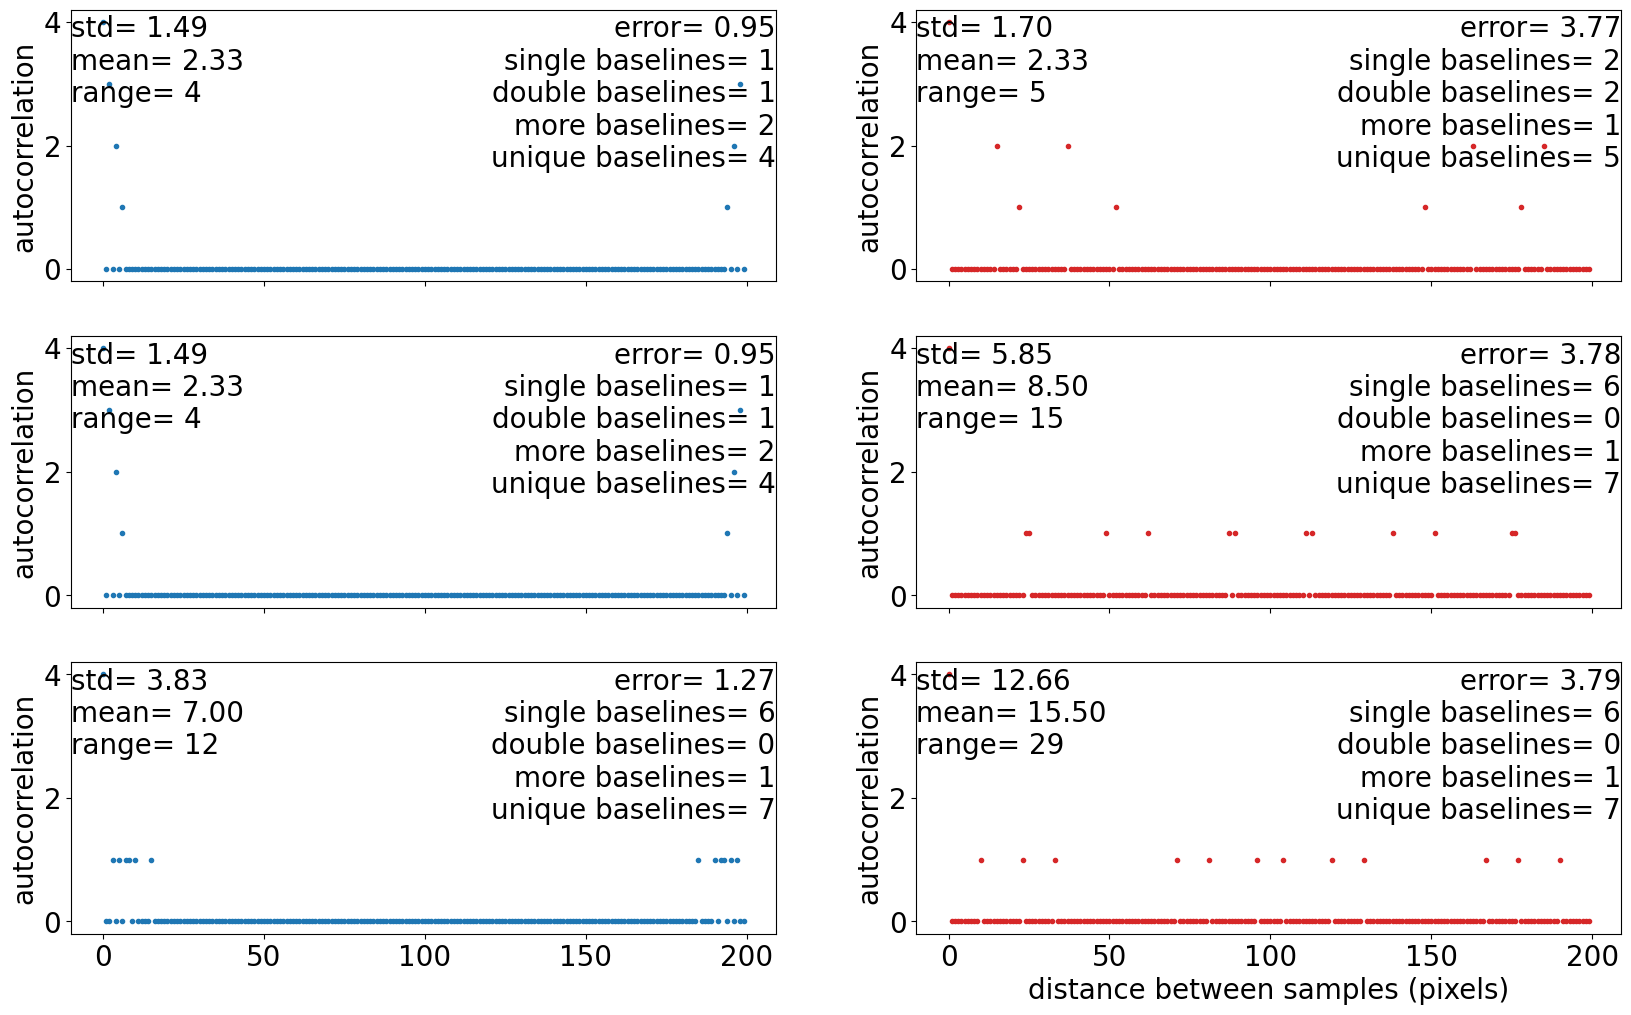

In [22]:
plots = np.arange(len(full_data))
plots = np.concatenate((plots[:best], plots[-worst:]))
colour = np.concatenate((["tab:blue"]*best, ["tab:red"]*worst))
n_plots = len(plots)

fig, axs = plt.subplots(n_plots//2, 2, figsize= (20,4*n_plots//2), sharex= True)
axs = axs.flatten("F")

for n, plot in enumerate(plots):
    axs[n].plot(autocor[plot], marker= ".", linestyle= "none", color= colour[n])
    axs[n].text(1, 0.98,
                "error= {0:.2f}\nsingle baselines= {1:d}\ndouble baselines= {2:d}\nmore baselines= {3:d}\nunique baselines= {4:d}".format(errors[plot], single_baselines[plot], double_baselines[plot], more_baselines[plot], unique_baselines[plot]),
                horizontalalignment='right', verticalalignment='top', transform= axs[n].transAxes)

    axs[n].text(0, 0.98,
                "std= {0:.2f}\nmean= {1:.2f}\nrange= {2:d}".format(np.std(autocor_indexs[n]), np.mean(autocor_indexs[n]), np.ptp(autocor_indexs[n])),
                horizontalalignment='left', verticalalignment='top', transform= axs[n].transAxes)
    axs[n].set(ylabel= "autocorrelation")

axs[-1].set(xlabel= "distance between samples (pixels)")
plt.show()

In [23]:
def autocorrelate3(x): #FFT varient
    x = x[~np.isnan(x)]
    x = x.astype(int)

    array = np.zeros(total_points)
    array[x] = 1.

    FT = np.fft.fft(array)
    resultFT = np.abs(FT)**2
    result = np.fft.ifft(resultFT)

    return result

autocor = [autocorrelate3(locations) for locations in full_data]
autocor = np.array(autocor)

C:\Users\syf83691\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\syf83691\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


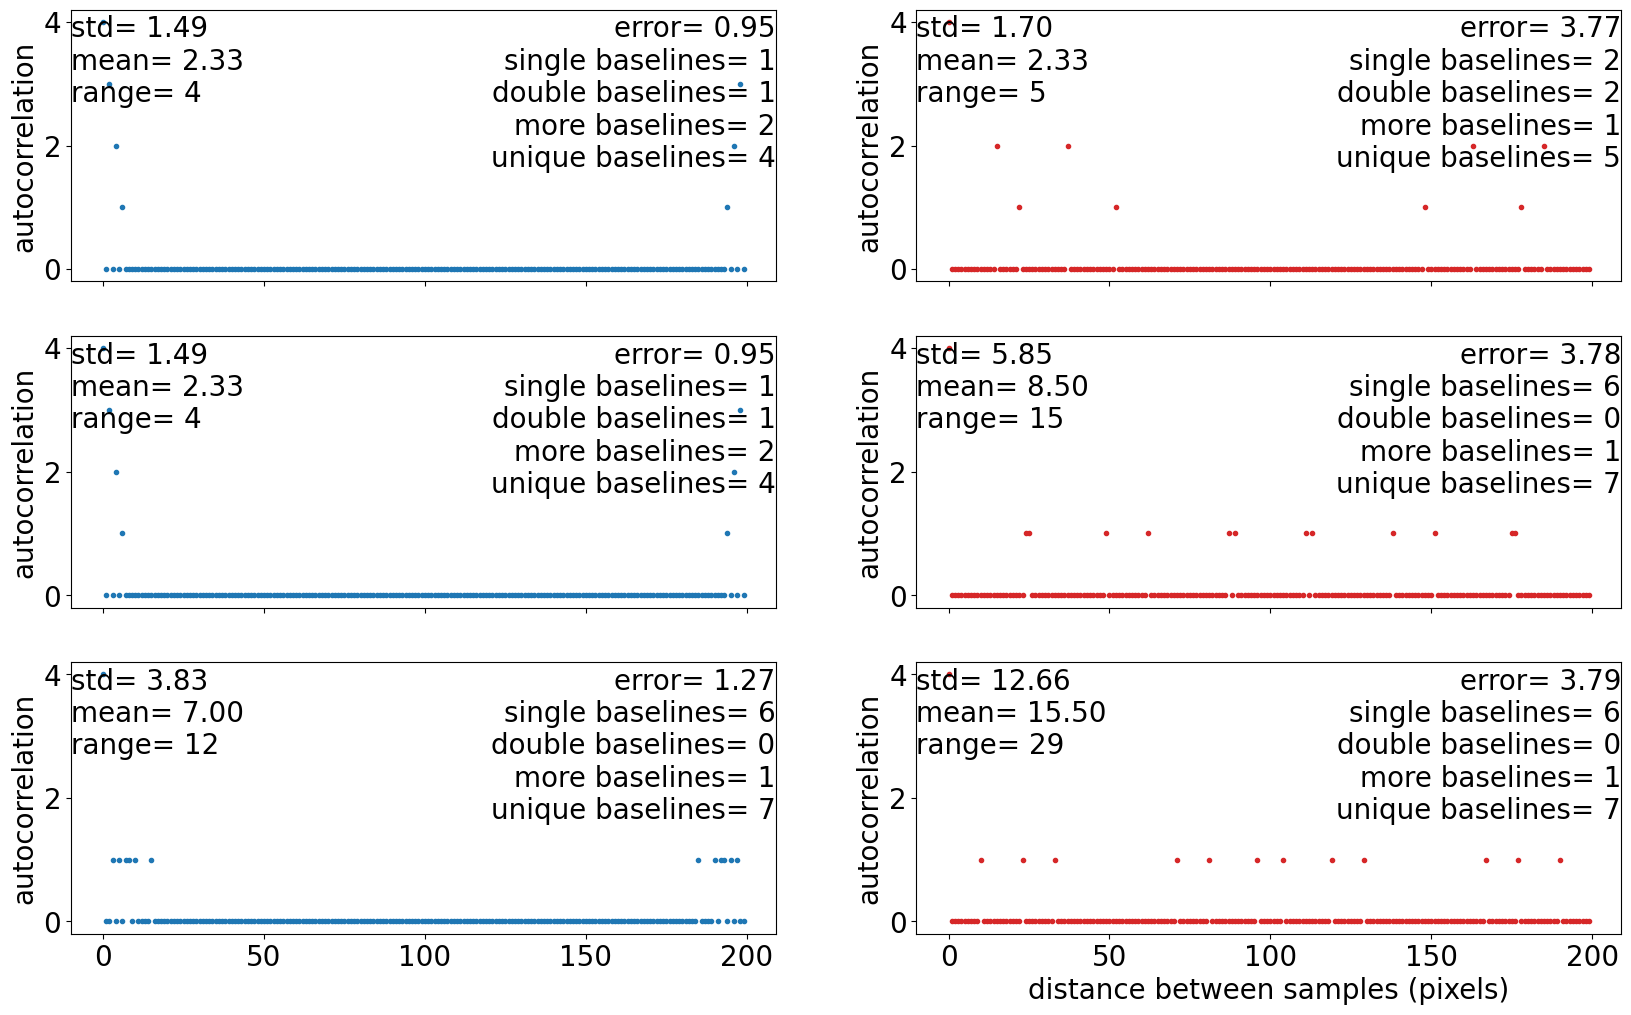

In [24]:
plots = np.arange(len(full_data))
plots = np.concatenate((plots[:best], plots[-worst:]))
colour = np.concatenate((["tab:blue"]*best, ["tab:red"]*worst))
n_plots = len(plots)

fig, axs = plt.subplots(n_plots//2, 2, figsize= (20,4*n_plots//2), sharex= True)
axs = axs.flatten("F")

for n, plot in enumerate(plots):
    axs[n].plot(autocor[plot], marker= ".", linestyle= "none", color= colour[n])
    axs[n].text(1, 0.98,
                "error= {0:.2f}\nsingle baselines= {1:d}\ndouble baselines= {2:d}\nmore baselines= {3:d}\nunique baselines= {4:d}".format(errors[plot], single_baselines[plot], double_baselines[plot], more_baselines[plot], unique_baselines[plot]),
                horizontalalignment='right', verticalalignment='top', transform= axs[n].transAxes)

    axs[n].text(0, 0.98,
                "std= {0:.2f}\nmean= {1:.2f}\nrange= {2:d}".format(np.std(autocor_indexs[n]), np.mean(autocor_indexs[n]), np.ptp(autocor_indexs[n])),
                horizontalalignment='left', verticalalignment='top', transform= axs[n].transAxes)
    axs[n].set(ylabel= "autocorrelation")

axs[-1].set(xlabel= "distance between samples (pixels)")
plt.show()

In [25]:
def unautocorrelate(result): # It's not possible to unautocorrelate stuff because it doesn't have a unique solution. However, I don't care about getting a unique solution. I just want one (of many) possible solution.
    resultFT = np.fft.fft(result)
    FT = np.sqrt(resultFT)

    # consider adding a random phase to see what happens

    array = np.fft.ifft(FT)

    return array

test = autocor[0]
test = unautocorrelate(test)

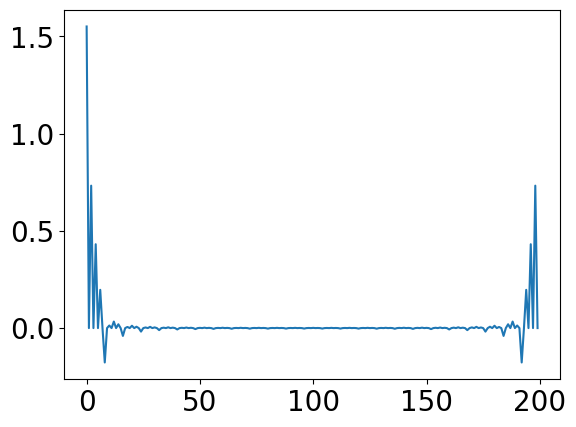

In [26]:
plt.plot(test) # Didn't work :(. I need a solution with dirac spikes, not just any solution.
plt.show()

In [27]:
def flatten_list(bookshelf):
    papers= []
    bookshelf = list(bookshelf)
    for book in bookshelf:
        if type(book) == str: #strings are iterable but should not be flattened
            papers.append(book)
            continue
        try:
            book[0]
        except: #This is not a list! Add this item to the papers. #Also why does numpy throw an IndexError whereas python throws a TypeError?!?
            papers.append(book)
        else:
            papers += flatten_list(book) #This is a list! Its items must be seperated first, then it can be added to the papers.
    return papers

In [28]:
n = 400
a = [0,1,4,10,21,40,64,95,-112,-78,-53,-30,-16,-8,-3,-1]

b = np.zeros(n)
b[a] = 1.

print(len(b), np.count_nonzero(b))
print(np.nonzero(b)[0])
print(n -np.nonzero(b)[0] -1)
print(np.count_nonzero(np.correlate(b, b, mode= "full") > 1))
print(np.correlate(b, b, mode= "full"))

400 16
[  0   1   4  10  21  40  64  95 288 322 347 370 384 392 397 399]
[399 398 395 389 378 359 335 304 111  77  52  29  15   7   2   0]
1
[ 1.  1.  1.  1.  1.  0.  1.  1.  1.  0.  1.  1.  1.  0.  0.  1.  1.  1.
  0.  1.  0.  1.  0.  1.  0.  1.  0.  0.  1.  1.  1.  0.  0.  1.  0.  0.
  1.  0.  0.  1.  1.  0.  1.  0.  0.  0.  0.  1.  0.  0.  1.  0.  1.  1.
  0.  1.  1.  0.  0.  0.  0.  0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  1.
  0.  1.  0.  0.  0.  1.  1.  1.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.
  0.  0.  1.  1.  0.  1.  0.  1.  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.
  0.  0.  1.  1.  1.  0.  0.  1.  1.  1.  0.  0.  0.  1.  0.  0.  1.  0.
  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.
  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.

In [29]:
np.argwhere(np.correlate(b, b, mode= "full") == 2)

array([], shape=(0, 1), dtype=int64)

In [30]:
import numpy as np

locs = {"left":[0,1,4,10,21,40,64,95,133,179], "right":[0,2,7,15,29,52,77,111,153,197]}
diffs = {"left": [], "right":[]}

for hand_name, hand_locs in locs.items():
    for n in hand_locs:
        for m in hand_locs:
            diffs[hand_name] += [m -n]

    diffs[hand_name] = np.array(diffs[hand_name])
    diffs[hand_name] = diffs[hand_name][diffs[hand_name] >= 0]

all_diffs = flatten_list(diffs.values())
all_diffs, counts = np.unique(all_diffs, return_counts= True)

if np.any(counts > 1):
    print("WARNING! The following baselines are duplicates: {0:}".format(all_diffs[counts > 1]))

possible_diffs = np.arange(all_diffs.max())
is_missing = np.isin(possible_diffs, all_diffs, invert= True)
print("Missing baselines include: {0:}".format(possible_diffs[is_missing]))

WARNING! The following baselines are duplicates: [0]
Missing baselines include: [ 12  16  18  26  28  32  33  35  41  47  49  51  53  56  57  58  61  65
  66  67  68  71  72  73  78  79  80  81  83  87  88  89  90  92  97  98
  99 100 102 103 105 106 107 108 110 113 114 116 117 118 119 121 122 125
 126 127 128 130 131 134 135 136 137 140 141 142 143 144 147 148 149 150
 152 154 155 156 157 159 160 161 162 163 164 165 166 167 170 171 172 173
 174 176 177 180 181 183 184 185 186 187 188 189 191 192 193 194 196]
